In [60]:
import torchvision.datasets as datasets
import torch
import matplotlib.pyplot as plt
import numpy as np

In [61]:
plt.rcParams["figure.figsize"] = (8,8)

In [62]:
from google.colab import files

In [63]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [64]:
mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [65]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [66]:
N = len(mnist_trainset)

In [67]:
mnist_trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [68]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

In [69]:
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

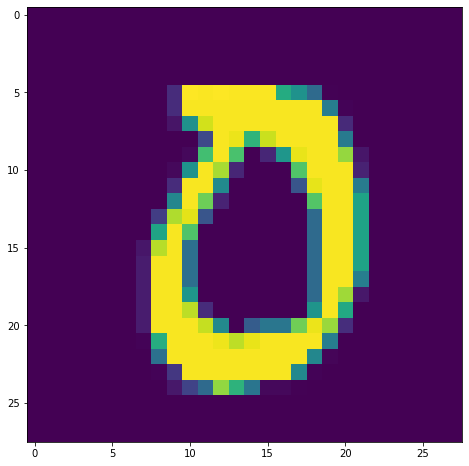

In [70]:
plt.imshow(mnist_testset.data[28,:,:])
plt.show()

In [71]:
data_vec = torch.reshape(mnist_trainset.data, (60000, 28*28)) # Make into vector
data_vec_test = torch.reshape(mnist_testset.data, (-1, 28*28)) # Make into vector

### Rather than estimating it directly using maximum likelihood, start by 
- estimating the data covariance matrix
- calculate the eigenvectors and eigenvalues
- to initialize 𝑊 (12.45)
- Then use eq 12.46 to calculate 𝜎

In [72]:
data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)

$W = U_M (L_M - \sigma^2 I)^{1/2}$  
U_M is DxM with columns being a subset of M eigenvectors of the covariance matrix.  
L_M is MxM diagonal with corresponding eigenvalues.  

In [73]:
D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])

In [74]:
sig_sq = sig_sq.double()

In [75]:
sig_sq.type

<function Tensor.type>

In [76]:
U_M = data_eig.eigenvectors[:,:2]
L_M = torch.diag(data_eig.eigenvalues[:2])

In [77]:
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5).double()

## 𝜇 is given by the population mean.

In [78]:
data_vec_double = data_vec.type(torch.DoubleTensor)
data_vec_test_double = data_vec_test.type(torch.DoubleTensor)

In [79]:
data_vec_double.shape

torch.Size([60000, 784])

In [80]:
mu = torch.mean(data_vec_double, 0)

In [81]:
mu.shape

torch.Size([784])

### Now evaluate and plot the expected value of z given x for all your input images.

$p(z|x) = N(z | M^{-1}W^T(x-\mu), \sigma^{-2}M)$  
$M = W^T W + \sigma^2 I$

In [82]:

M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)

In [83]:
N_test = 10000

In [84]:
M.shape

torch.Size([2, 2])

In [85]:
x_mu = data_vec_double.T - mu.repeat(N,1).T

In [86]:
x_mu_test = data_vec_test_double.T - mu.repeat(N_test,1).T

In [87]:
x_mu.shape

torch.Size([784, 60000])

In [88]:
temp = torch.inverse(M)@W.T

In [89]:
temp.shape

torch.Size([2, 784])

In [90]:
# x_mu_complex = x_mu.type(torch.complex64)
temp_double = temp.type(torch.double)

In [91]:
z_values = temp_double@x_mu

In [92]:
Z_values_test = temp_double@x_mu_test

In [93]:
z_values.shape

torch.Size([2, 60000])

In [94]:
Z_values_test.shape

torch.Size([2, 10000])

### Color the points by the digit labels. Does the Probabilistic PCA latent space separate the 10 digits?

It is best at 0 and 1 the rest are more overlapping. But some tendencies are seen.

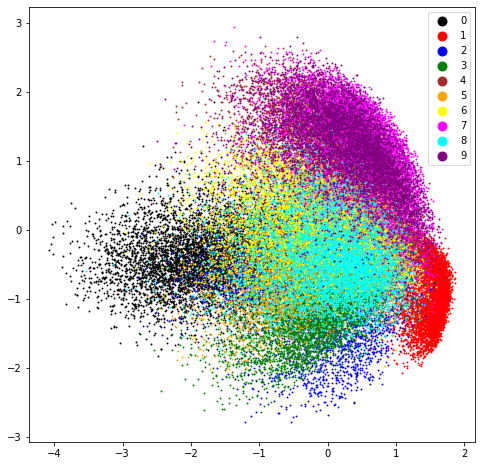

In [95]:
results_for_plot = z_values.detach().numpy().T

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_trainset.targets

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig("ppca_latent.png", bbox_tight=True)
plt.show()

In [96]:
!ls

data			 ppca_latent_train.png	ppca_trans_ex.png
ppca_latent.png		 ppca_meshgrid.png	sample_data
ppca_latent_sklearn.png  ppca_sample_test.png
ppca_latent_test.png	 ppca_sample_train.png


In [97]:
covar = sig_sq * torch.eye(W.shape[0]) + torch.matmul(W,W.T)
print(covar)

tensor([[3647.6975,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000, 3647.6975,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000, 3647.6975,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., 3647.6975,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000, 3647.6975,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
         3647.6975]], dtype=torch.float64)


In [98]:
print(M)

tensor([[3.3272e+05, 2.2893e-02],
        [2.2893e-02, 2.4328e+05]], dtype=torch.float64)


In [99]:
#Compute log (marginal) likelihood
def PPCA_mll(X, mu, sigma, W):
    mll = 0
    covar = sigma * torch.eye(W.shape[0]) + torch.matmul(W,W.T)
    gauss = torch.distributions.multivariate_normal.MultivariateNormal(mu, covar)
    for i in range(X.shape[0]):
      x = X[i]
      #print(f"for i={i}, gauss.log_prob(x)={gauss.log_prob(x)}")
      p_x = gauss.log_prob(x)
      if p_x > -3000:
        print(f"WOW! p_x={p_x}")
      mll += p_x
    return mll

In [100]:
mll = PPCA_mll(data_vec_double, mu, sig_sq, W)

In [101]:
mll

tensor(-2.5992e+08, dtype=torch.float64)

In [103]:
#Using sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
zs_sk = pca.fit_transform(data_vec)
zs_sk_test = pca.transform(data_vec_test)

In [104]:
#Return the average log-likelihood of all samples.
print(f"Train set: {pca.score(data_vec)}")
print(f"Test set: {pca.score(data_vec_test)}")

Train set: -4331.9229609596305
Test set: -4329.990577725487


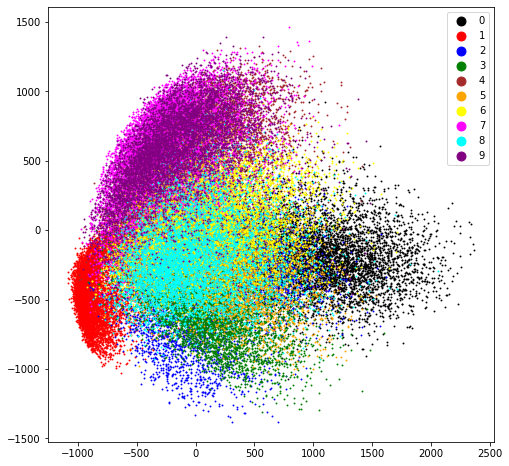

In [106]:
results_for_plot = zs_sk

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_trainset.targets

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig("ppca_latent_train.png", bbox_tight=True, transparent=True)
plt.show()

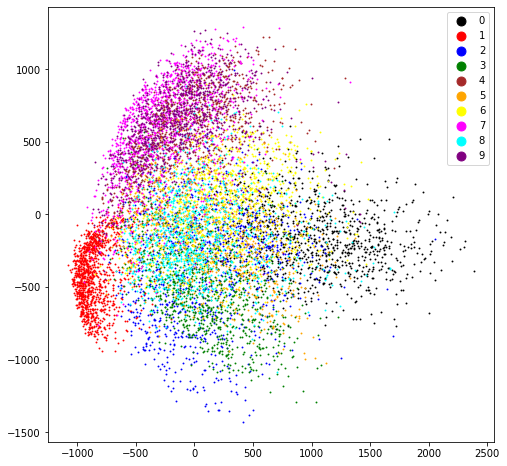

In [107]:
results_for_plot = zs_sk_test

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = mnist_testset.targets

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.savefig("ppca_latent_test.png", bbox_tight=True, transparent=True)
plt.show()

torch.Size([2])


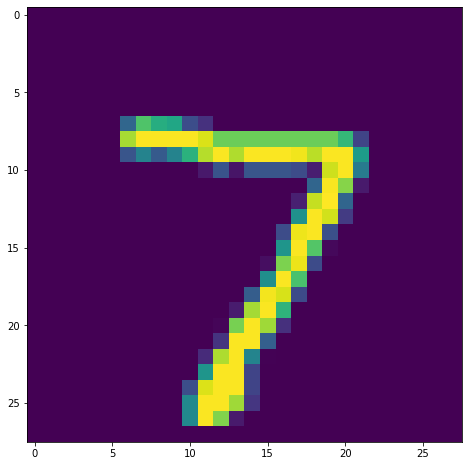

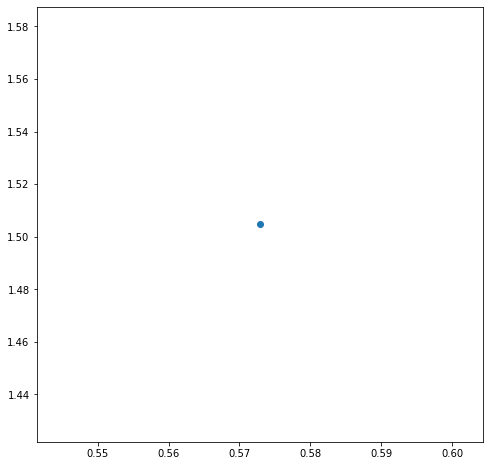

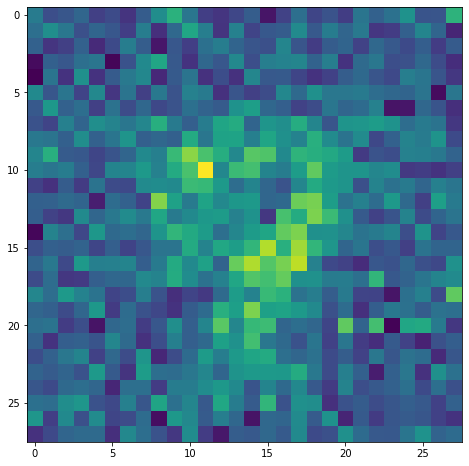

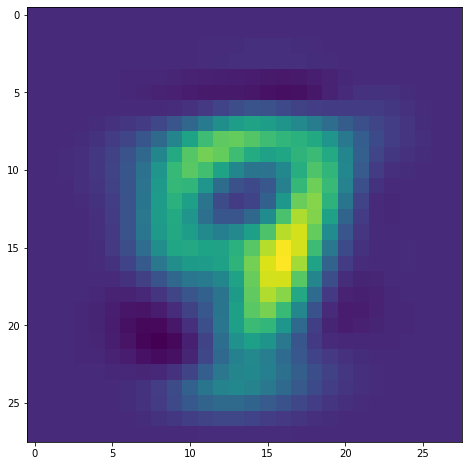

In [110]:
#Construct example of x -> z -> xhat
x = data_vec_test[0]
z = Z_values_test[:,0]
print(z.shape)
#Transform back to input space from latent space
mean = torch.matmul(W,z) + mu
covar = sig_sq*torch.eye(W.shape[0])
p_xz = torch.distributions.multivariate_normal.MultivariateNormal(mean.double(), covar.double())
sample = p_xz.sample()
plt.imshow(x.view(28,28))
plt.show()
plt.scatter(z[0], z[1])
plt.show()
plt.imshow(sample.view(28,28))
plt.show()
plt.imshow(mean.view(28,28))
plt.show()

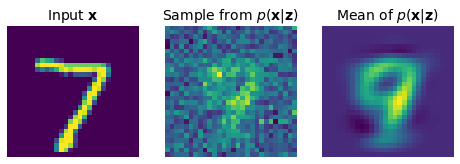

In [119]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x.view(28,28))
axs[1].imshow(sample.view(28,28))
axs[2].imshow(mean.view(28,28))
axs[0].axis("off")
axs[0].set_title("Input $\mathbf{x}$", fontsize=14)
axs[1].axis("off")
axs[1].set_title("Sample from $p(\mathbf{x} | \mathbf{z})$", fontsize=14)
axs[2].axis("off")
axs[2].set_title("Mean of $p(\mathbf{x} | \mathbf{z})$", fontsize=14)
fig.savefig("ppca_trans_ex.png", bbox_tight=True, transparent=True)
plt.show()

In [ ]:
gauss = torch.distributions.multivariate_normal.MultivariateNormal(mu, covar)

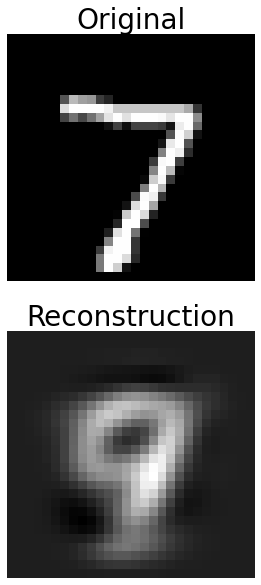

In [113]:
fig, axs = plt.subplots(2,1, figsize=(16,10))
axs[0].imshow(x.view(28,28), cmap="gray")
axs[1].imshow(mean.cpu().view(28,28), cmap="gray")
axs[0].set_title("Original", fontsize=28)
axs[1].set_title("Reconstruction", fontsize=28)
axs[0].axis("off")
axs[1].axis("off")
fig.savefig("ppca_sample_test.png", bbox_tight=True, transparent=True)
plt.show()

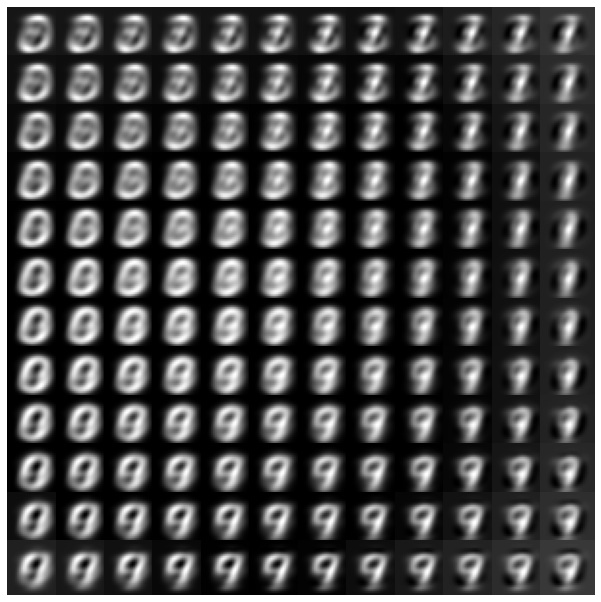

In [ ]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        z = torch.tensor([y_val, x_val]).double()
        mean = torch.matmul(W,z) + mu
        im = mean
        im_plt = im.reshape((28,28))
        plot_me = im_plt.cpu().detach().numpy()
        ax[i,j].imshow(plot_me, cmap="gray")
        ax[i,j].axis("off")

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis("off")
plt.savefig("ppca_meshgrid.png", bbox_tight=True, transparant=True)
plt.show()

In [114]:
files.download("ppca_trans_ex.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
files.download("ppca_sample_test.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
files.download("ppca_latent_test.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [117]:
files.download("ppca_latent_train.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("ppca_meshgrid.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>